In [ ]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
# Valeria Quiroz  - Gabriel Zapata
%%time
!pip install kaggle
api_token = {"username":"gabrielzapata","key":"45d11139cb4e32995898eae373213b5f"}
import json
import zipfile
import os
with open('/content/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!mkdir /root/.kaggle      
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c ga-customer-revenue-prediction
if not os.path.exists("/content/competitions/ga-customer-revenue-prediction"):
    os.makedirs("/content/competitions/ga-customer-revenue-prediction")
os.chdir('/content/competitions/ga-customer-revenue-prediction')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

- path is now set to: /content
  0% 0.00/5.23M [00:00<?, ?B/s]
100% 5.23M/5.23M [00:00<00:00, 86.4MB/s]
 99% 56.0M/56.8M [00:00<00:00, 63.4MB/s]
100% 56.8M/56.8M [00:00<00:00, 89.3MB/s]
100% 1.11G/1.11G [00:11<00:00, 103MB/s] 
100% 1.11G/1.11G [00:11<00:00, 99.7MB/s]
 97% 59.0M/61.1M [00:00<00:00, 90.6MB/s]
100% 61.1M/61.1M [00:00<00:00, 113MB/s] 
 96% 320M/333M [00:03<00:00, 103MB/s] 
100% 333M/333M [00:03<00:00, 101MB/s]
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 84.1MB/s]
CPU times: user 1min 40s, sys: 48 s, total: 2min 28s
Wall time: 5min 11s


### **Librerias**

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from pandas import json_normalize
import seaborn as sns 
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import plotly.graph_objs as go
from plotly import subplots
import plotly.offline as py
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import datetime
from sklearn.model_selection import  GroupKFold
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM, GRU
import numpy as np
import tensorflow as tf,keras    
from tensorflow.keras.models import Sequential  
#from sklearn.metrics import mean_absolute_percentage_error

### **Explicacion del codigo json sacado de Kaggle, para aplanar los datos**

In [ ]:
def load_df(csv_path='/content/competitions/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [ ]:
%%time
train_df = load_df()
#test_df = load_df('/content/competitions/ga-customer-revenue-prediction/test.csv')

Loaded train.csv. Shape: (903653, 55)
CPU times: user 2min 6s, sys: 10.3 s, total: 2min 17s
Wall time: 2min 24s


In [ ]:
train_df = train_df.drop( ['sessionId'] + ["trafficSource.campaignCode"], axis=1)
print(train_df.shape)

(903653, 53)


### **Eliminemos columnas constantes e imputar valores cero a NAN**

In [ ]:
print ("Antes de eliminar columnas constantes - shape de train y test datasets: ", train_df.shape)
train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()]
print ("Despues de eliminar columnas constantes - shape de train y test datasets: ", train_df.shape)

Antes de eliminar columnas constantes - shape de train y test datasets:  (903653, 53)
Despues de eliminar columnas constantes - shape de train y test datasets:  (903653, 34)


In [ ]:
# Replace NaN values throughout train dataset
train_df.replace(to_replace=np.nan, value=0, inplace=True)

### **Conversion variable categórica a númerica**

In [ ]:
# etiqueta codifica las variables categóricas y convierte las variables numéricas flotantes
cat_cols = ["channelGrouping", "device.browser",'fullVisitorId',
            "device.deviceCategory", "device.operatingSystem", "device.isMobile",
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    


num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
   

channelGrouping
device.browser
fullVisitorId
device.deviceCategory
device.operatingSystem
device.isMobile
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [ ]:
train_df.to_csv('dataset.csv')

In [ ]:
#######Debido a que las neuronas se sobreajustan por valores tan altos codificamos ######
lbl1=preprocessing.LabelEncoder()
train_df['fullVisitorId']=lbl1.fit_transform(list(train_df['fullVisitorId'].values.astype('str')))
#lbl1.classes_
###lbl1.inverse_transform(train_df['fullVisitorId'])#por si se desea codificar valores originales

In [ ]:
Y = np.log1p(train_df["totals.transactionRevenue"].astype('float'))
X=train_df.drop(["totals.transactionRevenue"],axis=1)##Eliminamos la salida de los datos de las caracteristicas
X=X.drop(["date"],axis=1)

In [ ]:
#X['fullVisitorId']=X['fullVisitorId'].values.astype('float')

In [ ]:
groupsTrain = X['fullVisitorId']
group_kfold = GroupKFold(n_splits=2)

In [ ]:
train_index, test_index = next(GroupKFold(n_splits=4).split(X,Y, groupsTrain)) 
X_train = X.iloc[train_index]
Y_train= Y.iloc[train_index]
X_test = X.iloc[test_index]
Y_test = Y.iloc[test_index]   
    

In [ ]:
######Convesor a tensor######
def Conv2tensor(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float64)
  return arg

In [ ]:
X_traint = Conv2tensor(X_train)
Y_traint= Conv2tensor(Y_train)
X_testt = Conv2tensor(X_test)
Y_testt = Conv2tensor(Y_test)   

In [3]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=10*1000,
  decay_rate=1,
  staircase=False)

In [4]:
def model2(Neuronas=32 ,dropout=0.1 ,Acti='relu'):
    model = Sequential()
    model.add(Dense(Neuronas, input_dim=32, activation='relu'))
    model.add(Dense(Neuronas/2, activation=Acti))
    model.add(Dense(Neuronas/8, activation=Acti))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation = 'linear'))
    rmse=tf.keras.metrics.RootMeanSquaredError()
    mae=tf.keras.metrics.MeanAbsoluteError()
    opt=keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer= opt , loss= 'mse', metrics=[ rmse , mae ] )
    return model

In [ ]:
groups = X_train['fullVisitorId']
group_kfold= GroupKFold(n_splits=3).split(X_train,Y_train, groups) 

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
batch=256

epoch=10

num_cell=[ 64 , 128 , 256 , 512 , 1024 ]

Drop=[0.1 , 0.2, 0.3 , 0.4, 0.5 ]


param_grid = dict( Neuronas = num_cell , dropout = Drop  )


# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid =  GridSearchCV( estimator  = KerasRegressor( build_fn = model2 , batch_size = batch ,epochs = epoch ) ,
                      param_grid = param_grid,
                      scoring = 'neg_root_mean_squared_error',
                      n_jobs     =  20,
                      cv         = group_kfold, 
                      refit      = True,
                      verbose    = 2,
                      return_train_score = True
                     )


In [ ]:
historyMSE=grid.fit(X_train,Y_train, groups)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  1.0min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=20)]: Done  75 out of  75 | elapsed: 15.7min finished


Epoch 1/10
2648/2648 [==============================] - 12s 4ms/step - loss: 137964766172754.9219 - root_mean_squared_error: 8723518.4596 - mean_absolute_error: 1940763.5150
Epoch 2/10
2648/2648 [==============================] - 12s 4ms/step - loss: 4.0257 - root_mean_squared_error: 2.0062 - mean_absolute_error: 0.2268
Epoch 3/10
2648/2648 [==============================] - 11s 4ms/step - loss: 4.0222 - root_mean_squared_error: 2.0055 - mean_absolute_error: 0.2265
Epoch 4/10
2648/2648 [==============================] - 11s 4ms/step - loss: 4.0919 - root_mean_squared_error: 2.0228 - mean_absolute_error: 0.2306
Epoch 5/10
2648/2648 [==============================] - 12s 5ms/step - loss: 4.0453 - root_mean_squared_error: 2.0112 - mean_absolute_error: 0.2280
Epoch 6/10
2648/2648 [==============================] - 12s 5ms/step - loss: 4.0857 - root_mean_squared_error: 2.0208 - mean_absolute_error: 0.2301
Epoch 7/10
2648/2648 [==============================] - 12s 5ms/step - loss: 3.9763 - 

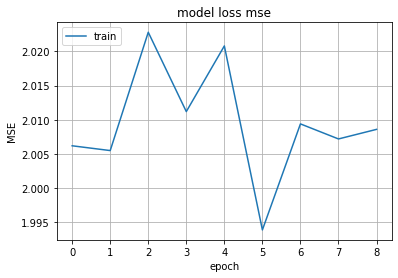

In [ ]:
Trainmse= np.array([ 2.0062, 2.0055, 2.0228, 2.0112, 2.0208, 1.9939, 2.0094, 2.0072, 2.0086])
plt.plot(Trainmse)
plt.title('model loss mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
TrainValRMSE=grid.cv_results_

In [ ]:
grid.best_params_

{'Neuronas': 256, 'dropout': 0.3}

In [9]:
Esquema=model2(256,0.3)
Esquema.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 45,505
Trainable params: 45,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
j=0
for i in  TrainValRMSE.get('params'):
     j+=1
     if i == grid.best_params_ :
        index=j-1

In [ ]:
ErrorValRMSE=-1*(TrainValRMSE.get('split0_test_score')[index]+TrainValRMSE.get('split1_test_score')[index]+TrainValRMSE.get('split2_test_score')[index])/3
ErrorValRMSE

2.005065834168042

In [ ]:
ErrorTrainRMSE=-1*(TrainValRMSE.get('split0_train_score')[index]+TrainValRMSE.get('split1_train_score')[index]+TrainValRMSE.get('split2_train_score')[index])/3
ErrorTrainRMSE

2.005525729554671

In [ ]:
-1*grid.best_score_#confirma el calculo del error de validacion

2.005065834168042

In [ ]:
Model=grid.best_estimator_

In [ ]:
pred_test_y1= Model.predict(X_testt)

In [ ]:
pred_test_y1[pred_test_y1<0]=0
print(f"RMSE= {np.sqrt(metrics.mean_squared_error(Y_test,pred_test_y1))}")
print(f"MAE= {metrics.mean_absolute_error(Y_test,pred_test_y1)}")

RMSE= 2.0346052285441667
MAE= 0.24935417259439988


In [ ]:
test_pred_df = pd.DataFrame({"fullVisitorId":X_test["fullVisitorId"].values})
test_pred_df["transactionRevenue"] = (Y_test.values)
test_pred_df["PredictedRevenue"] = (pred_test_y1)
test_pred_df = test_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print('RMSE')
print(np.sqrt(metrics.mean_squared_error(test_pred_df["transactionRevenue"].values, test_pred_df["PredictedRevenue"].values)))
print('MAE')
print((metrics.mean_absolute_error((test_pred_df["transactionRevenue"].values ),(test_pred_df["PredictedRevenue"].values))))

RMSE
3.208199756060181
MAE
0.3142071529608511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Scoring MAE

In [ ]:
groups = X_train['fullVisitorId']
group_kfold= GroupKFold(n_splits=3).split(X_train,Y_train, groups) 

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================

num_cell=[ 64 , 128 , 256 , 512 , 1024 ]

Drop=[0.1 , 0.2, 0.3 , 0.4, 0.5 ]

param_grid = dict( Neuronas = num_cell , dropout = Drop )


# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid1 =  GridSearchCV( estimator  = KerasRegressor( build_fn = model2 , batch_size = batch ,epochs = epoch ) ,
                     param_grid = param_grid ,
                     scoring = 'neg_mean_absolute_error',
                     n_jobs     =  20 ,
                     cv         = group_kfold , 
                     refit      = True ,
                     verbose    = 2 ,
                     return_train_score = True
                     )


In [ ]:
historyMAE=grid1.fit(X_train,Y_train, groups)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   58.1s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=20)]: Done  75 out of  75 | elapsed: 16.0min finished


Epoch 1/10
2648/2648 [==============================] - 19s 7ms/step - loss: 181829088467918.9062 - root_mean_squared_error: 10224457.8575 - mean_absolute_error: 2621384.1699
Epoch 2/10
2648/2648 [==============================] - 19s 7ms/step - loss: 8.3129 - root_mean_squared_error: 2.8756 - mean_absolute_error: 0.7100
Epoch 3/10
2648/2648 [==============================] - 19s 7ms/step - loss: 4.5277 - root_mean_squared_error: 2.1272 - mean_absolute_error: 0.4431
Epoch 4/10
2648/2648 [==============================] - 18s 7ms/step - loss: 4.0705 - root_mean_squared_error: 2.0174 - mean_absolute_error: 0.3891
Epoch 5/10
2648/2648 [==============================] - 18s 7ms/step - loss: 4.0525 - root_mean_squared_error: 2.0129 - mean_absolute_error: 0.3878
Epoch 6/10
2648/2648 [==============================] - 19s 7ms/step - loss: 3.9412 - root_mean_squared_error: 1.9851 - mean_absolute_error: 0.3865
Epoch 7/10
2648/2648 [==============================] - 19s 7ms/step - loss: 4.1021 -

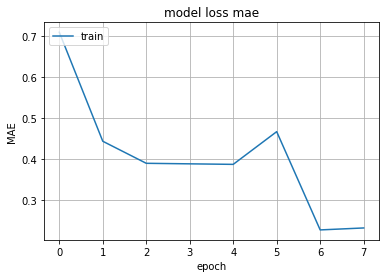

In [ ]:
Trainmae= np.array([ 0.7100, 0.4431, 0.3891, 0.3878, 0.3865, 0.4666, 0.2260, 0.2308])
plt.plot(Trainmae)
plt.title('model loss mae')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
TrainValMAE=grid1.cv_results_

In [ ]:
grid1.best_params_

{'Neuronas': 512, 'dropout': 0.3}

In [8]:
Esquema1=model2(512,0.3)
Esquema1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               16896     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 164,737
Trainable params: 164,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
j=0

for i in  TrainValMAE.get('params'):
     j+=1
     if i == grid1.best_params_ :
        index=j-1
        

In [ ]:
ErrorValMAE=-1*(TrainValMAE.get('split0_test_score')[index]+TrainValMAE.get('split1_test_score')[index]+TrainValMAE.get('split2_test_score')[index])/3
ErrorValMAE

0.22723007292140293

In [ ]:
ErrorTrainMAE=-1*(TrainValMAE.get('split0_train_score')[index]+TrainValMAE.get('split1_train_score')[index]+TrainValMAE.get('split2_train_score')[index])/3
ErrorTrainMAE

0.22722075077360138

In [ ]:
-1*grid1.best_score_#confirma el calculo del error de validacion

0.22723007292140293

In [ ]:
ModelMAE=grid1.best_estimator_

In [ ]:
pred_test_y2= ModelMAE.predict(X_testt)

In [ ]:
pred_test_y2[pred_test_y2<0]=0
print(f"RMSE= {np.sqrt(metrics.mean_squared_error(Y_test,pred_test_y2))}")
print(f"MAE= {metrics.mean_absolute_error(Y_test,pred_test_y2)}")

RMSE= 2.0365046723166675
MAE= 0.23239116668632773


In [ ]:
test_pred_df = pd.DataFrame({"fullVisitorId":X_test["fullVisitorId"].values})
test_pred_df["transactionRevenue"] =  (Y_test.values)
test_pred_df["PredictedRevenue"] = (pred_test_y2)
test_pred_df = test_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print('RMSE')
print(np.sqrt(metrics.mean_squared_error(test_pred_df["transactionRevenue"].values, test_pred_df["PredictedRevenue"].values)))
print('MAE')
print((metrics.mean_absolute_error((test_pred_df["transactionRevenue"].values ),(test_pred_df["PredictedRevenue"].values))))

RMSE
3.2196965701005125
MAE
0.2939901879579358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

